# Random Forest 

## Importing Libraries

In [234]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, fbeta_score, precision_score
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from functools import partial
from sklearn.feature_selection import mutual_info_classif, SelectKBest

## Loading the Data


In [235]:
import pandas as pd
data_test = pd.read_csv("data_test.csv")
data_train = pd.read_csv("data_train.csv")

data_train.head()



,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,glucose_level_diagnosis
0,25283,Female,48.0,False,False,True,Private,Urban,69.21,33.1,never smoked,False,hypoglycemia
1,43734,Male,15.0,False,False,False,Private,Rural,122.25,21.0,never smoked,False,non-diabetic
2,47113,Female,67.0,False,False,True,Self-employed,Rural,110.42,24.9,never smoked,False,non-diabetic
3,56996,Male,44.0,False,False,True,Private,Urban,65.41,24.8,smokes,False,hypoglycemia
4,26325,Male,14.0,False,False,False,Govt_job,Urban,82.34,31.6,never smoked,False,non-diabetic


In [236]:
data_test.tail()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,glucose_level_diagnosis
1017,39120,Female,82.0,False,False,False,Self-employed,Urban,82.21,26.0,never smoked,False,non-diabetic
1018,48989,Female,34.0,False,False,False,Govt_job,Rural,120.06,33.0,never smoked,False,non-diabetic
1019,27382,Female,50.0,False,False,True,Govt_job,Urban,92.15,20.8,never smoked,False,non-diabetic
1020,36204,Male,15.0,False,False,False,children,Rural,62.57,32.3,never smoked,False,hypoglycemia
1021,16868,Female,51.0,False,False,True,Private,Rural,83.30,34.0,formerly smoked,False,non-diabetic


## Preprocessing
The data has been already somewhat processed and the training set balanaced. However the model requiers the data to be all numerical. Also there are still some missing values in the bmi column and the useless id column.


In [237]:
# Dropping the ID column, as it is not needed for the model
data_train = data_train.drop(columns=['id'])
data_test = data_test.drop(columns=['id'])

In [238]:
# lets see how much data are we missing
print(data_train.isna().sum())
print(data_test.isna().sum())

gender                     0
age                        0
hypertension               0
heart_disease              0
ever_married               0
work_type                  0
Residence_type             0
avg_glucose_level          0
bmi                        0
smoking_status             0
stroke                     0
glucose_level_diagnosis    0
dtype: int64
gender                      0
age                         0
hypertension                0
heart_disease               0
ever_married                0
work_type                   0
Residence_type              0
avg_glucose_level           0
bmi                        31
smoking_status              0
stroke                      0
glucose_level_diagnosis     0
dtype: int64


### Imputing BMI with mean

In [239]:
imputer = SimpleImputer(strategy='mean')  


imputer.fit(data_train[['bmi']])  # Fit on the training data
data_train['bmi'] = imputer.transform(data_train[['bmi']])
data_test['bmi'] = imputer.transform(data_test[['bmi']])
print(data_test.isna().sum())

gender                     0
age                        0
hypertension               0
heart_disease              0
ever_married               0
work_type                  0
Residence_type             0
avg_glucose_level          0
bmi                        0
smoking_status             0
stroke                     0
glucose_level_diagnosis    0
dtype: int64


### Encoding

Before encoding, it is important to asses what kind of features are we dealing with

In [240]:
numerical_variables=["age","bmi","avg_glucose_level"]
nominal_columns = ['gender', 'work_type', 'Residence_type', 'smoking_status', 'glucose_level_diagnosis'] 
boolean_columns = ['hypertension', 'heart_disease', 'ever_married',"stroke"] 
#ordinal_variables= ["smoking_status"]
target_variable = "stroke"



One hot encoder will be used.

In our original dataset, we have mostly categorical data. 
There are not that many categories though, so the dummy variables wont increase the dimnesionality so drastically. It is therefore the preferred option.


In [241]:
for col in boolean_columns:
    data_train[col] = data_train[col].astype(int)
    data_test[col] = data_test[col].astype(int)
   

In [242]:

# Apply one-hot encoding to nominal variables
onehot_encoder = OneHotEncoder(sparse_output=False, drop='first',handle_unknown='ignore')  # Optional: drop first to avoid multicollinearity
data_train_nominal = onehot_encoder.fit_transform(data_train[nominal_columns])
data_test_nominal = onehot_encoder.transform(data_test[nominal_columns])

# Create DataFrames from the encoded arrays
nominal_features_train = pd.DataFrame(data_train_nominal, columns=onehot_encoder.get_feature_names_out(nominal_columns))
nominal_features_test = pd.DataFrame(data_test_nominal, columns=onehot_encoder.get_feature_names_out(nominal_columns))

# Drop the original nominal columns
data_train.drop(columns=nominal_columns, inplace=True)
data_test.drop(columns=nominal_columns, inplace=True)

# Concatenate the new one-hot encoded columns
data_train = pd.concat([data_train, nominal_features_train], axis=1)
data_test = pd.concat([data_test, nominal_features_test], axis=1)




c:\Users\tomas\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


### Spliting into X's and y's

In [243]:
X_test = data_test.drop(columns=['stroke'])
y_test = data_test['stroke']

X_train = data_train.drop(columns=['stroke'])
y_train = data_train['stroke']


## Modeling

### The Baseline Model

In our project, we use a baseline model that operates by predicting the most frequent class observed in the training dataset. Given that the distribution of our target variable, "stroke," is heavily skewed towards "no stroke," the baseline model will consistently predict "no stroke" for all inputs. This method provides a simple but effective benchmark for comparing the performance of more complex models in our analysis.


Accuracy: 0.9510763209393346
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022

ROC AUC: 0.5


c:\Users\tomas\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\tomas\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\tomas\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


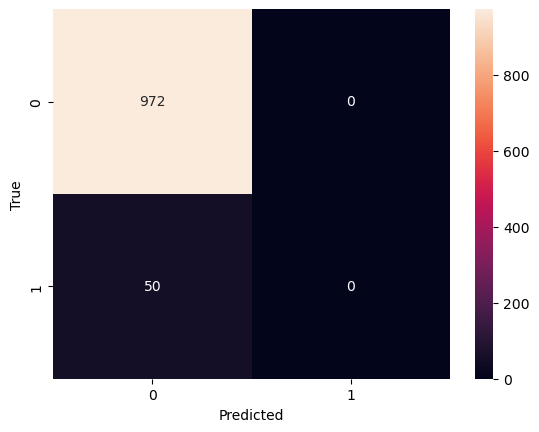

In [244]:
most_frequent_class = 0

# Create an array of predictions for the most frequent class
y_pred_most_frequent = np.full(shape=y_test.shape, fill_value=most_frequent_class)

# Evaluate the metrics
print("Accuracy:", accuracy_score(y_test, y_pred_most_frequent))
print(classification_report(y_test, y_pred_most_frequent))
print("ROC AUC:", roc_auc_score(y_test, y_pred_most_frequent))


# ploting the confusion matrix
cm_base = confusion_matrix(y_test, y_pred_most_frequent)
sns.heatmap(cm_base, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()



The baseline model obviously fails to identify any positive cases, while maintaing a deceptive high accuracy score of 95%

Accuracy might not be the best metric to focus on. Ideally we would want to identify most of the positive cases, even at the cost of misclassifying some negative cases.

### The basic RFC model

In [245]:
# Defining the model
model = RandomForestClassifier(random_state= 42, n_estimators=100) # 100 trees
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [246]:
RandomForestClassifierScore = model.score(X_test, y_test)
print("Accuracy obtained by Random Forest Classifier model:",RandomForestClassifierScore*100)

print(classification_report(y_test, model.predict(X_test)))

Accuracy obtained by Random Forest Classifier model: 95.00978473581213
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.33      0.02      0.04        50

    accuracy                           0.95      1022
   macro avg       0.64      0.51      0.51      1022
weighted avg       0.92      0.95      0.93      1022



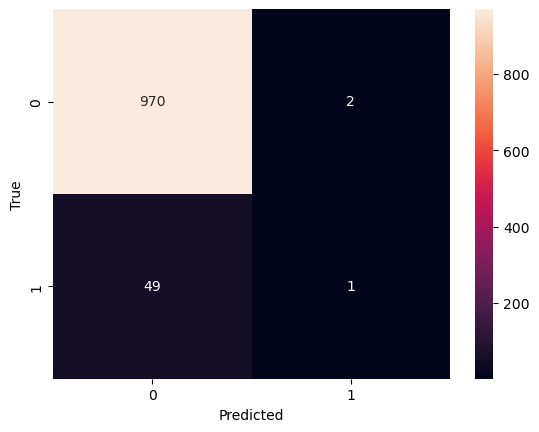

In [247]:
#PLot of Confusion Matrix
cm_basic = confusion_matrix(y_test, model.predict(X_test))
sns.heatmap(cm_basic, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Obviously much better performance than the baseline model. Although the accuracy is smaller, we identified correctly 2% of all positive cases and 33% of the positive-predicted were actually positive.

## Chosing the metrics of interest

It quite common in medical studies or machine learning using medical data, to use f-beta score. F-beta is the wheighted harmonic mean of precision and recall, where beta denotes the  ratio of recall importance to precision importance.

We shall pick the F1 score, giving both metrics the same importance.

We will also define a cost matrix and comapre/ grade model based on it.

### Cost matrix

As false negative statement about having a stroke is more severe than a false positive statement, we chose C(FN) = 5 and c(FP) = 1, costs of true predctions both left at 0.

In [248]:
# Deffine the cost matrix
cost_matrix = np.array([[0, 1], [10, 0]])
cost_matrix

array([[ 0,  1],
       [10,  0]])

### Optimizing the RFC model 

We will search the hyperparameter space using random search.

In [249]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score, recall_score

param_grid = {
    'max_depth': [3, 5, 10, 15],
    'n_estimators': [100, 200, 300, 500],
    'criterion': ['entropy'],
    'min_samples_split': [20, 30, 50, 100],
    'min_samples_leaf': [30, 50, 100],
    'class_weight': [{0:1, 1:5}, {0:1, 1:10}, {0:1, 1:20}]
}

# Define the precision scorer for the positive class
f1_positive_scorer = make_scorer(f1_score, pos_label=1)
#recall_positive_scorer = make_scorer(recall_score, pos_label=1)

# Initialize the grid search
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    cv=3,
    verbose=1,
    scoring=f1_positive_scorer,
    random_state=42

)

# Fit the grid search to the data
random_search.fit(X_train, y_train)
print("Best Parameters:", random_search.best_params_)
best_model = random_search.best_estimator_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'n_estimators': 300, 'min_samples_split': 50, 'min_samples_leaf': 30, 'max_depth': 15, 'criterion': 'entropy', 'class_weight': {0: 1, 1: 10}}


In [250]:
random_search.best_score_

0.2493671744059943

In [251]:
random_search_rfc_predict_test = random_search.predict(X_test)
print(classification_report(y_test, random_search_rfc_predict_test))

              precision    recall  f1-score   support

           0       0.98      0.90      0.94       972
           1       0.22      0.56      0.32        50

    accuracy                           0.88      1022
   macro avg       0.60      0.73      0.63      1022
weighted avg       0.94      0.88      0.91      1022



In [252]:
y_train_pred = best_model.predict(X_train)
y_pred = best_model.predict(X_test)
train_f1_score = f1_score(y_train_pred, y_train, pos_label=1)
test_f1_score = f1_score(y_pred, y_test, pos_label=1)

print(f"Training set f1_score: {train_f1_score}")
print(f"Test set f1_score: {test_f1_score}")

Training set f1_score: 0.36723910171730517
Test set f1_score: 0.3181818181818182


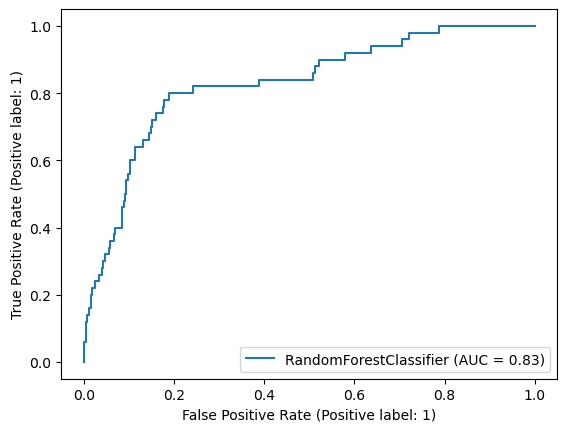

In [253]:
from sklearn.metrics import RocCurveDisplay

clf_disp = RocCurveDisplay.from_estimator(best_model, X_test, y_test)
plt.show()

AUC of 83% is a strong indicator that the model has a good predictive ability

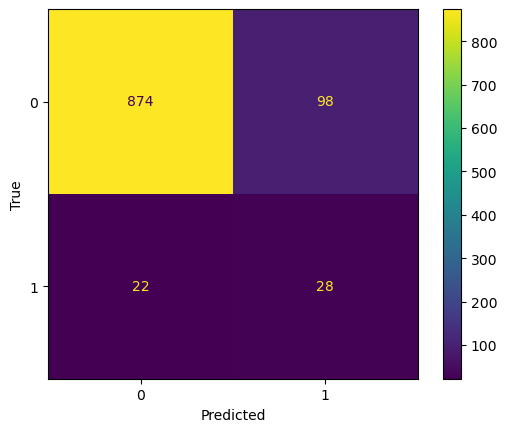

In [254]:
from sklearn.metrics import ConfusionMatrixDisplay


cm_optim = confusion_matrix(y_test, best_model.predict(X_test))
ConfusionMatrixDisplay.from_predictions(y_test, best_model.predict(X_test))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Implementing a classification treshold

<Figure size 800x600 with 0 Axes>

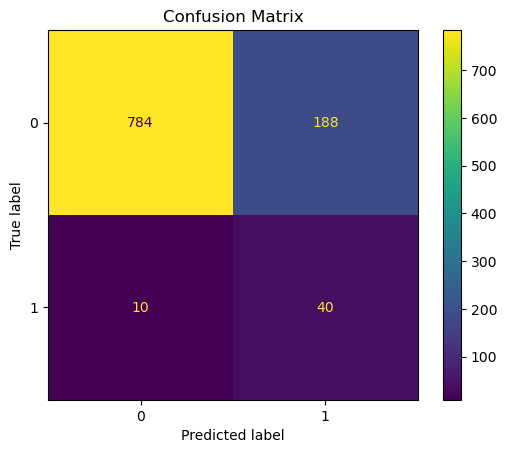

In [255]:
from sklearn.metrics import ConfusionMatrixDisplay

y_pred_tres = [True if val>0.4 else False for val in best_model.predict_proba(X_test)[:,1]]

cm_optim_tres = confusion_matrix(y_test, y_pred_tres)
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_tres)
plt.title('Confusion Matrix')
plt.show()


In [256]:
# Classifications report
print(classification_report(y_test, y_pred_tres))

              precision    recall  f1-score   support

           0       0.99      0.81      0.89       972
           1       0.18      0.80      0.29        50

    accuracy                           0.81      1022
   macro avg       0.58      0.80      0.59      1022
weighted avg       0.95      0.81      0.86      1022



In [257]:
# Classifications report
print(classification_report(y_test, best_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      0.90      0.94       972
           1       0.22      0.56      0.32        50

    accuracy                           0.88      1022
   macro avg       0.60      0.73      0.63      1022
weighted avg       0.94      0.88      0.91      1022



## Ealuation

In [258]:
cost_base = np.sum(cost_matrix * cm_base)
print(f"The total cost of the baseline classifier is {cost_base}.")

cost_basic = np.sum(cost_matrix * cm_basic)
print(f"The total cost of the non-optimized classifier is {cost_basic}.")

cost_optim = np.sum(cost_matrix * cm_optim)
print(f"The total cost of the optimized classifier is {cost_optim}.")

cost_optim_tres = np.sum(cost_matrix * cm_optim_tres)
print(f"The total cost of the optimized classifier with threshold is {cost_optim_tres}.")


The total cost of the baseline classifier is 500.
The total cost of the non-optimized classifier is 492.
The total cost of the optimized classifier is 318.
The total cost of the optimized classifier with threshold is 288.


### Classification of a single instance

In [259]:
chosen_inst = X_test.iloc[[69,]]
chosen_inst



,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,gender_Male,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_never smoked,smoking_status_smokes,glucose_level_diagnosis_hypoglycemia,glucose_level_diagnosis_non-diabetic,glucose_level_diagnosis_pre-diabetic
69,18.0,0,0,0,108.87,21.5,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [260]:
best_model.predict_proba(chosen_inst)
# The model is 99.3% confident that the patient will not have a stroke, which is consistent with the true label of 0.

array([[0.99339876, 0.00660124]])

In [261]:
# Saving our preprocessed data to two new csv files
data_train.to_csv("data_train_preprocessed.csv", index=False)
data_test.to_csv("data_test_preprocessed.csv", index=False)

## Conclusion



***The data was***:
  - heavily imbalanced towards the negative class
  - medical in nature - potentially a life/death situation
  - had some missing values

Due to the nature of the data, we chose F-1 as the evaluation metric.

***The main steps taken were:***
  - Additional preprocessing
  - Encoding
  - Modeling - Random Search


***The best model turned out to have this configuration***
- **n_estimators: 300** -> The model uses 300 decision trees
- **min_samples_split: 50** -> At least 50 samples are required to create a new decision node
- **min_samples_leaf: 30** -> Each leaf node must contain at least 30 samples
- **max_depth: 15** -> Each tree is allowed a maximum of 15 levels of depth
- **criterion: 'entropy'** -> Aiming for maximum information gain from each decision made within the trees.
- **class_weight: {0: 1, 1: 10}** -> Class '0' is given a weight of 1, and class '1' is more heavily weighted at 10, emphasizing its importance

+ +**Classification treshold of 0.4**


Overall, the model tends to correctly identify most of the positive instances, while misclassifying some of the negative instances. Both classes have almost the same recall.

The precision-recall trade-off can be hard to balance, but we are confident that recall is more important in this case and would be more useful in practical applications.


 ```
              precision    recall  f1-score   support

           0       0.99      0.81      0.89       972
           1       0.18      0.80      0.29        50

    accuracy                           0.81      1022
   macro avg       0.58      0.80      0.59      1022
weighted avg       0.95      0.81      0.86      1022
 ```

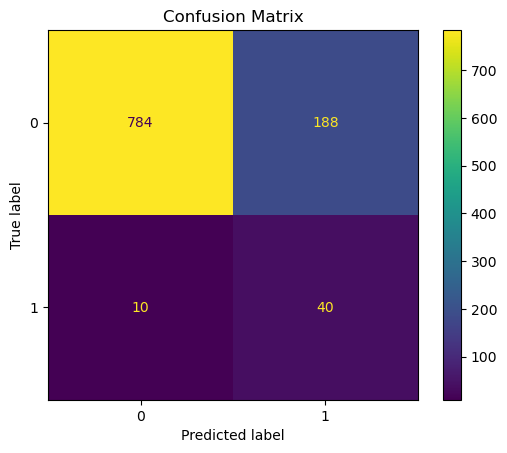